# Creating `H3-tiles`

Most [tiled web maps](https://en.wikipedia.org/wiki/Tiled_web_map) follow certain Google Maps conventions:

- Tiles are 256x256 pixels
- At the outer most zoom level, 0, the entire world can be rendered in a single map tile.
- Each zoom level doubles in both dimensions, so a single tile is replaced by 4 tiles when zooming in. 
- The [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) projection is used, with latitude limits of around 85 degrees.

OpenStreetMap, Google Maps, MapBox, etc. use the standard known as [Slippy Map Tilenames](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames) or XYZ:

- Tiles are 256 × 256 pixel PNG files
- Each zoom level (z) is a directory, each column (x) is a subdirectory, and each tile (y) in that column is a file
- Filename (url) format is `http://.../z/x/y.png`

The conversion between tiles and coordinates has been described [here](https://www.maptiler.com/google-maps-coordinates-tile-bounds-projection/) ([source code](https://gist.github.com/maptiler/fddb5ce33ba995d5523de9afdf8ef118#file-globalmaptiles-py)). 

On the other hand, [H3](https://h3geo.org/) is a geospatial indexing system that partitions the world into hexagonal cells. H3 is a hierarchical geospatial index. H3 indexes refer to cells by the spatial hierarchy. Every hexagonal cell, up to the maximum resolution supported by H3, has seven child cells below it in this hierarchy. This subdivision is referred to as aperture 7. 

H3 enables the user to subdivide areas into smaller and smaller hexagons. H3 supports sixteen resolutions. Each finer resolution has cells with one seventh the area of the coarser resolution. We have to keep in mind that the zoom level and the resolution are different things.

In this notbook we will find the conversion between tiles and H3 hexagonal cells.

## Import libraries

In [1]:
import h3
import os
import math
import json
import getpass
import requests
import psycopg2
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt

## Tile coordinates for each zoom level

In [2]:
import math

class GlobalMercator(object):
    """
    TMS Global Mercator Profile
    ---------------------------
    Functions necessary for generation of tiles in Spherical Mercator projection,
    EPSG:900913 (EPSG:gOOglE, Google Maps Global Mercator), EPSG:3785, OSGEO:41001.
    Such tiles are compatible with Google Maps, Microsoft Virtual Earth, Yahoo Maps,
    UK Ordnance Survey OpenSpace API, ...
    and you can overlay them on top of base maps of those web mapping applications.
    
    Pixel and tile coordinates are in TMS notation (origin [0,0] in bottom-left).
    What coordinate conversions do we need for TMS Global Mercator tiles::
         LatLon      <->       Meters      <->     Pixels    <->       Tile     
     WGS84 coordinates   Spherical Mercator  Pixels in pyramid  Tiles in pyramid
         lat/lon            XY in metres     XY pixels Z zoom      XYZ from TMS 
        EPSG:4326           EPSG:900913                                         
         .----.              ---------               --                TMS      
        /      \     <->     |       |     <->     /----/    <->      Google    
        \      /             |       |           /--------/          QuadTree   
         -----               ---------         /------------/                   
       KML, public         WebMapService         Web Clients      TileMapService
    What is the coordinate extent of Earth in EPSG:900913?
      [-20037508.342789244, -20037508.342789244, 20037508.342789244, 20037508.342789244]
      Constant 20037508.342789244 comes from the circumference of the Earth in meters,
      which is 40 thousand kilometers, the coordinate origin is in the middle of extent.
      In fact you can calculate the constant as: 2 * math.pi * 6378137 / 2.0
      $ echo 180 85 | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:900913
      Polar areas with abs(latitude) bigger then 85.05112878 are clipped off.
    What are zoom level constants (pixels/meter) for pyramid with EPSG:900913?
      whole region is on top of pyramid (zoom=0) covered by 256x256 pixels tile,
      every lower zoom level resolution is always divided by two
      initialResolution = 20037508.342789244 * 2 / 256 = 156543.03392804062
    What is the difference between TMS and Google Maps/QuadTree tile name convention?
      The tile raster itself is the same (equal extent, projection, pixel size),
      there is just different identification of the same raster tile.
      Tiles in TMS are counted from [0,0] in the bottom-left corner, id is XYZ.
      Google placed the origin [0,0] to the top-left corner, reference is XYZ.
      Microsoft is referencing tiles by a QuadTree name, defined on the website:
      http://msdn2.microsoft.com/en-us/library/bb259689.aspx
    The lat/lon coordinates are using WGS84 datum, yeh?
      Yes, all lat/lon we are mentioning should use WGS84 Geodetic Datum.
      Well, the web clients like Google Maps are projecting those coordinates by
      Spherical Mercator, so in fact lat/lon coordinates on sphere are treated as if
      the were on the WGS84 ellipsoid.
     
      From MSDN documentation:
      To simplify the calculations, we use the spherical form of projection, not
      the ellipsoidal form. Since the projection is used only for map display,
      and not for displaying numeric coordinates, we don't need the extra precision
      of an ellipsoidal projection. The spherical projection causes approximately
      0.33 percent scale distortion in the Y direction, which is not visually noticable.
    How do I create a raster in EPSG:900913 and convert coordinates with PROJ.4?
      You can use standard GIS tools like gdalwarp, cs2cs or gdaltransform.
      All of the tools supports -t_srs 'epsg:900913'.
      For other GIS programs check the exact definition of the projection:
      More info at http://spatialreference.org/ref/user/google-projection/
      The same projection is degined as EPSG:3785. WKT definition is in the official
      EPSG database.
      Proj4 Text:
        +proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0
        +k=1.0 +units=m +nadgrids=@null +no_defs
      Human readable WKT format of EPGS:900913:
         PROJCS["Google Maps Global Mercator",
             GEOGCS["WGS 84",
                 DATUM["WGS_1984",
                     SPHEROID["WGS 84",6378137,298.2572235630016,
                         AUTHORITY["EPSG","7030"]],
                     AUTHORITY["EPSG","6326"]],
                 PRIMEM["Greenwich",0],
                 UNIT["degree",0.0174532925199433],
                 AUTHORITY["EPSG","4326"]],
             PROJECTION["Mercator_1SP"],
             PARAMETER["central_meridian",0],
             PARAMETER["scale_factor",1],
             PARAMETER["false_easting",0],
             PARAMETER["false_northing",0],
             UNIT["metre",1,
                 AUTHORITY["EPSG","9001"]]]
    """
    
    def __init__(self, tileSize=256):
        "Initialize the TMS Global Mercator pyramid"
        self.tileSize = tileSize
        self.initialResolution = 2 * math.pi * 6378137 / self.tileSize
        # 156543.03392804062 for tileSize 256 pixels
        self.originShift = 2 * math.pi * 6378137 / 2.0
        # 20037508.342789244
        
    def MetersToLatLon(self, mx, my ):
        "Converts XY point from Spherical Mercator EPSG:900913 to lat/lon in WGS84 Datum"

        lon = (mx / self.originShift) * 180.0
        lat = (my / self.originShift) * 180.0

        lat = 180 / math.pi * (2 * math.atan( math.exp( lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    def Resolution(self, zoom ):
        "Resolution (meters/pixel) for given zoom level (measured at Equator)"
        
        # return (2 * math.pi * 6378137) / (self.tileSize * 2**zoom)
        return self.initialResolution / (2**zoom)
        
    def PixelsToMeters(self, px, py, zoom):
        "Converts pixel coordinates in given zoom level of pyramid to EPSG:900913"

        res = self.Resolution( zoom )
        mx = px * res - self.originShift
        my = py * res - self.originShift
        return mx, my
        

    def TileBounds(self, tx, ty, zoom):
        "Returns bounds of the given tile in EPSG:900913 coordinates"
        
        minx, miny = self.PixelsToMeters( tx*self.tileSize, ty*self.tileSize, zoom )
        maxx, maxy = self.PixelsToMeters( (tx+1)*self.tileSize, (ty+1)*self.tileSize, zoom )
        return ( minx, miny, maxx, maxy )
        
    def TileLonLatBounds(self, tx, ty, zoom ):
        "Returns bounds of the given tile in latutude/longitude using WGS84 datum"

        bounds = self.TileBounds( tx, ty, zoom)
        minLat, minLon = self.MetersToLatLon(bounds[0], bounds[1])
        maxLat, maxLon = self.MetersToLatLon(bounds[2], bounds[3])
         
        return ( minLon, minLat, maxLon, maxLat )
    
    def GoogleTile(self, tx, ty, zoom):
        "Converts TMS tile coordinates to Google Tile coordinates and vice versa"
        
        # coordinate origin is moved from bottom-left to top-left corner of the extent
        return tx, (2**zoom - 1) - ty

In [3]:
def TileCoordinates (z):
    """Tile coordinates for a given z"""
    return np.arange(int(np.sqrt(4**z)))

In [4]:
def TileBbox(minZ, maxZ):
    """Tile bounding boxes for a given range of zoom levels"""
    gdf = gpd.GeoDataFrame(columns=['z', 'x', 'y','bbox'])
    bboxes = []
    Z = []
    X = []
    Y = []
    
    ## Get bounding box
    zVals = np.arange(minZ,maxZ+1)
    for z in zVals:
        xVals = TileCoordinates(z)
        yVals = TileCoordinates(z)
        for x in xVals:
            for y in yVals:
                # Get bounding box
                x_TMS, y_TMS = GM.GoogleTile(x,y,z)
                bbox = list(GM.TileLonLatBounds(x_TMS,y_TMS,z))
                Z.append(z)
                X.append(x)
                Y.append(y)
        
                # Replace 180.0 with 179.99
                bbox = [x if x != 180.0 else 179.99 for x in bbox]
                bbox = [x if x != -180.0 else -179.99 for x in bbox]
                
                bboxes.append(bbox)
                
    gdf['z'] = Z
    gdf['x'] = X
    gdf['y'] = Y
    gdf['bbox'] = bboxes
    
    gdf['geometry'] = gdf['bbox'].apply(lambda x: geometry.box(x[0], x[1], x[2], x[3]))
    
    gdf.crs = "EPSG:4326"
       
    return gdf

In [5]:
GM = GlobalMercator()

In [6]:
tiles = TileBbox(4, 6)
tiles

z   x   y                                               bbox  \
0     4   0   0  [-179.99, 82.67628497834903, -157.500000000000...   
1     4   0   1  [-179.99, 79.17133464081945, -157.500000000000...   
2     4   0   2  [-179.99, 74.01954331150228, -157.500000000000...   
3     4   0   3  [-179.99, 66.51326044311185, -157.500000000000...   
4     4   0   4  [-179.99, 55.7765730186677, -157.5000000000000...   
...  ..  ..  ..                                                ...   
5371  6  63  59  [174.37500000000003, -82.67628497834903, 179.9...   
5372  6  63  60  [174.37500000000003, -83.35951133035451, 179.9...   
5373  6  63  61  [174.37500000000003, -83.97925949886205, 179.9...   
5374  6  63  62  [174.37500000000003, -84.54136107313408, 179.9...   
5375  6  63  63  [174.37500000000003, -85.05112877980659, 179.9...   

                                               geometry  
0     POLYGON ((-157.50000 82.67628, -157.50000 85.0...  
1     POLYGON ((-157.50000 79.17133, -157.50000 82.6...  
2     POLYGON ((-157.50000 74.01954, -157.50000 79.1...  
3     POLYGON ((-157.50000 66.51326, -157.50000 74.0...  
4     POLYGON ((-157.50000 55.77657, -157.50000 66.5...  
...                                                 ...  
5371  POLYGON ((179.99000 -82.67628, 179.99000 -81.9...  
5372  POLYGON ((179.99000 -83.35951, 179.99000 -82.6...  
5373  POLYGON ((179.99000 -83.97926, 179.99000 -83.3...  
5374  POLYGON ((179.99000 -84.54136, 179.99000 -83.9...  
5375  POLYGON ((179.99000 -85.05113, 179.99000 -84.5...  

[5376 rows x 5 columns]

**Display tiles**

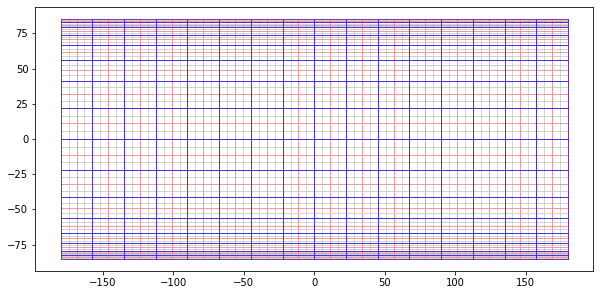

In [7]:
colors = ['k', 'r', 'b', 'g']
fig, ax = plt.subplots(figsize=(10,10))
for n, z in enumerate(tiles['z'].unique()[::-1]):
    tiles[tiles['z'] == z].plot(ax=ax, color='w', edgecolor=colors[n], alpha=0.5)

## Convert bounding boxes to H3 hexagons

For convenience, you can use [H3-Pandas](https://github.com/DahnJ/H3-Pandas).

In [8]:
import h3pandas

We will use the following H3 resolutions for each zoom levels. See the [H3 resolution](https://h3geo.org/docs/core-library/restable/) table for more details.

In [9]:
z_res = {'4':3, '5':3, '6':6}

We can add H3 hexagons using the function [`polyfill`](https://h3-pandas.readthedocs.io/en/latest/h3pandas.html#h3pandas.h3pandas.H3Accessor.polyfill). This method adds a list of H3 cells whose centroid falls into each polygon. If we want to explode the values horizontally (ending up with as many rows as there are H3 cells), we can use the parameter explode

In [10]:
tiles_h3 = gpd.GeoDataFrame(columns=['z', 'x', 'y', 'bbox', 'geometry', 'h3_polyfill', 'resolution'])
for n,z in tqdm(enumerate(tiles['z'].unique())):
    gdf = tiles[tiles['z'] == z]
    gdf_h3 = gdf.h3.polyfill(z_res[str(z)], explode=True)
    gdf_h3['resolution'] = z_res[str(z)]
    
    tiles_h3 = pd.concat([tiles_h3, gdf_h3])

3it [03:04, 61.48s/it]


**Display 4 contiguous tiles**

In [11]:
tiles_h3

z   x   y                                               bbox  \
0     4   0   0  [-179.99, 82.67628497834903, -157.500000000000...   
0     4   0   0  [-179.99, 82.67628497834903, -157.500000000000...   
0     4   0   0  [-179.99, 82.67628497834903, -157.500000000000...   
0     4   0   0  [-179.99, 82.67628497834903, -157.500000000000...   
0     4   0   0  [-179.99, 82.67628497834903, -157.500000000000...   
...  ..  ..  ..                                                ...   
5375  6  63  63  [174.37500000000003, -85.05112877980659, 179.9...   
5375  6  63  63  [174.37500000000003, -85.05112877980659, 179.9...   
5375  6  63  63  [174.37500000000003, -85.05112877980659, 179.9...   
5375  6  63  63  [174.37500000000003, -85.05112877980659, 179.9...   
5375  6  63  63  [174.37500000000003, -85.05112877980659, 179.9...   

                                               geometry      h3_polyfill  \
0     POLYGON ((-157.50000 82.67628, -157.50000 85.0...  8303a4fffffffff   
0     POLYGON ((-157.50000 82.67628, -157.50000 85.0...  830316fffffffff   
0     POLYGON ((-157.50000 82.67628, -157.50000 85.0...  83056bfffffffff   
0     POLYGON ((-157.50000 82.67628, -157.50000 85.0...  8303a5fffffffff   
0     POLYGON ((-157.50000 82.67628, -157.50000 85.0...  830569fffffffff   
...                                                 ...              ...   
5375  POLYGON ((179.99000 -85.05113, 179.99000 -84.5...  86f39b05fffffff   
5375  POLYGON ((179.99000 -85.05113, 179.99000 -84.5...  86f39b28fffffff   
5375  POLYGON ((179.99000 -85.05113, 179.99000 -84.5...  86f39b007ffffff   
5375  POLYGON ((179.99000 -85.05113, 179.99000 -84.5...  86f39b0a7ffffff   
5375  POLYGON ((179.99000 -85.05113, 179.99000 -84.5...  86f39b727ffffff   

     resolution  
0             3  
0             3  
0             3  
0             3  
0             3  
...         ...  
5375          6  
5375          6  
5375          6  
5375          6  
5375          6  

[14150341 rows x 7 columns]

We can then utilize the method `h3_to_geo_boundary` to obtain the geometries for the H3 cells. It expects that the index already has the H3 cell ids.

This process takes a while so we take a subset.

In [12]:
z = 6; x = 30; y=24

In [13]:
tiles_h3 = tiles_h3[(tiles_h3['z'] == z) & ((tiles_h3['x'] == x) | (tiles_h3['x'] == x+1)) & ((tiles_h3['y'] == y) | (tiles_h3['y'] == y-1))]

In [14]:
tiles_h3 = tiles_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()

In [15]:
tiles_h3

z   x   y                                               bbox  \
h3_polyfill                                                                     
863920257ffffff  6  30  23  [-11.249999999999993, 40.979898069620155, -5.6...   
8618594dfffffff  6  30  23  [-11.249999999999993, 40.979898069620155, -5.6...   
86185a577ffffff  6  30  23  [-11.249999999999993, 40.979898069620155, -5.6...   
863935967ffffff  6  30  23  [-11.249999999999993, 40.979898069620155, -5.6...   
863924bb7ffffff  6  30  23  [-11.249999999999993, 40.979898069620155, -5.6...   
...             ..  ..  ..                                                ...   
8639013a7ffffff  6  31  24  [-5.625000000000013, 36.5978891330702, 0.0, 40...   
863908337ffffff  6  31  24  [-5.625000000000013, 36.5978891330702, 0.0, 40...   
86391d277ffffff  6  31  24  [-5.625000000000013, 36.5978891330702, 0.0, 40...   
863909d07ffffff  6  31  24  [-5.625000000000013, 36.5978891330702, 0.0, 40...   
86390a507ffffff  6  31  24  [-5.625000000000013, 36.5978891330702, 0.0, 40...   

                                                          geometry resolution  
h3_polyfill                                                                    
863920257ffffff  POLYGON ((-7.57219 42.31491, -7.61412 42.30112...          6  
8618594dfffffff  POLYGON ((-5.63836 43.74925, -5.68091 43.73656...          6  
86185a577ffffff  POLYGON ((-7.86278 44.65820, -7.90615 44.64478...          6  
863935967ffffff  POLYGON ((-10.34794 41.63003, -10.38968 41.614...          6  
863924bb7ffffff  POLYGON ((-9.31807 43.52065, -9.36086 43.50637...          6  
...                                                            ...        ...  
8639013a7ffffff  POLYGON ((-5.00252 39.83018, -5.04273 39.81694...          6  
863908337ffffff  POLYGON ((-2.71000 39.29045, -2.74952 39.27801...          6  
86391d277ffffff  POLYGON ((-4.16171 37.93372, -4.20079 37.92045...          6  
863909d07ffffff  POLYGON ((-2.31688 39.60704, -2.35649 39.59483...          6  
86390a507ffffff  POLYGON ((-3.89916 37.95673, -3.93821 37.94357...          6  

[23643 rows x 6 columns]

<AxesSubplot:>

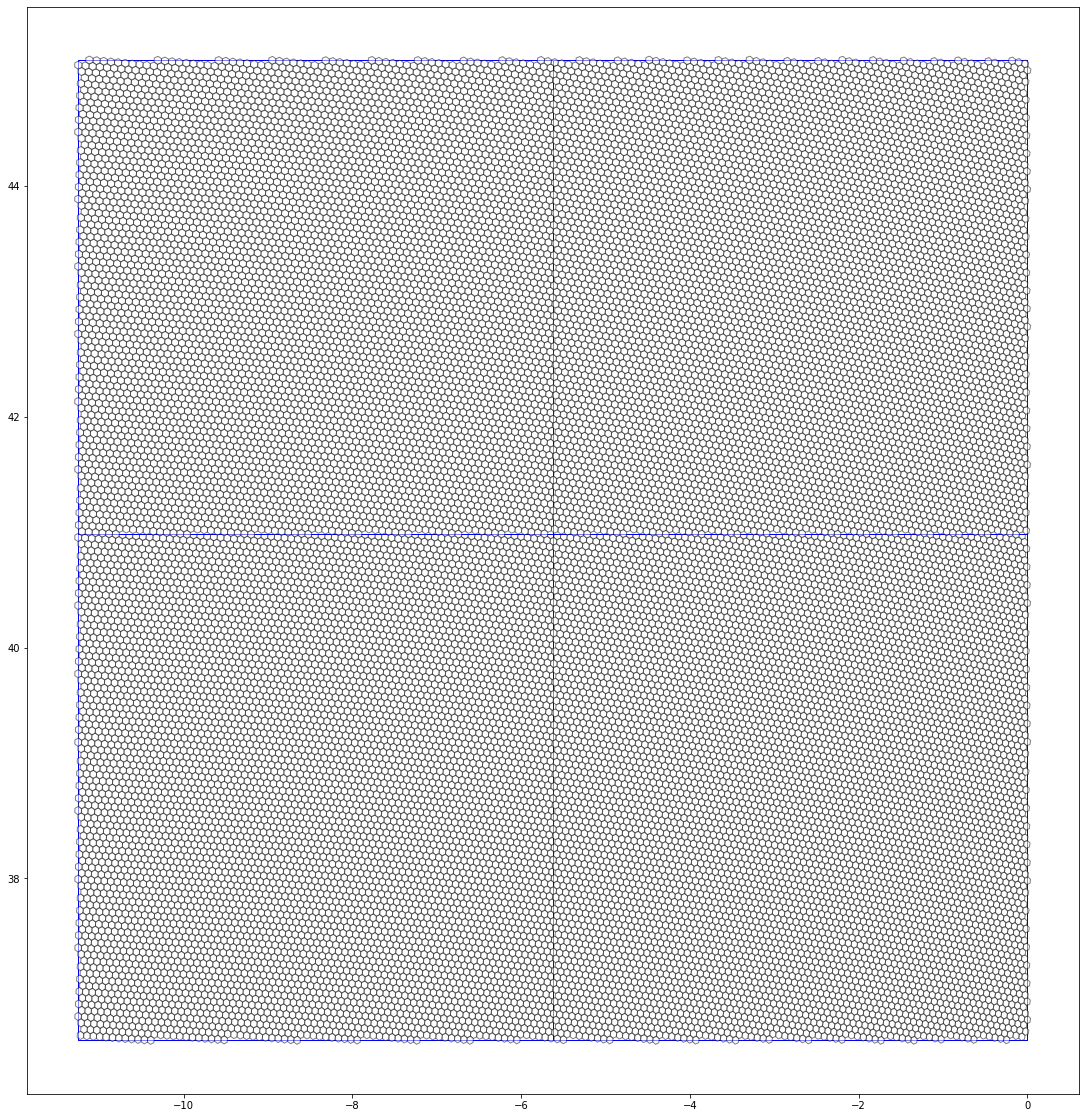

In [16]:
fig, ax = plt.subplots(figsize=(20,20))

tiles[(tiles['z'] == z) & (tiles['x'] == x) & (tiles['y'] == y)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x) & (tiles_h3['y'] == y)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

tiles[(tiles['z'] == z) & (tiles['x'] == x) & (tiles['y'] == y-1)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x) & (tiles_h3['y'] == y-1)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

tiles[(tiles['z'] == z) & (tiles['x'] == x+1) & (tiles['y'] == y)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x+1) & (tiles_h3['y'] == y)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

tiles[(tiles['z'] == z) & (tiles['x'] == x+1) & (tiles['y'] == y-1)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x+1) & (tiles_h3['y'] == y-1)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

## Connecting to the database

We create a dictionary with the environment variables

In [17]:
env = {
    "API_HOST": getpass.getpass('API_HOST:'),
    "API_POSTGRES_PORT": getpass.getpass('API_POSTGRES_PORT:'),
    "API_POSTGRES_USERNAME": getpass.getpass('API_POSTGRES_USERNAME:'),
    "API_POSTGRES_PASSWORD": getpass.getpass('API_POSTGRES_PASSWORD:'),
}

API_HOST: ············
API_POSTGRES_PORT: ····
API_POSTGRES_USERNAME: ···········
API_POSTGRES_PASSWORD: ···········


Create a new database session and return a connection object

In [18]:
conn = psycopg2.connect(
       host=env['API_HOST'],
       port=env['API_POSTGRES_PORT'],
       user=env['API_POSTGRES_USERNAME'],
       password=env['API_POSTGRES_PASSWORD']
   )

In [19]:
cursor = conn.cursor()

We select the MAPSPAM production table and get the `h3index`es for 4 different tiles.

In [20]:
table = 'h3_grid_spam2010v2r0_global_prod'

In [21]:
z = 6; x = 30; y=24
gdf_zxy = tiles_h3[(tiles_h3['z'] == z) & ((tiles_h3['x'] == x) | (tiles_h3['x'] == x+1)) & ((tiles_h3['y'] == y) | (tiles_h3['y'] == y-1))]
gdf_zxy.reset_index(inplace=True)
gdf_zxy.rename(columns={'h3_polyfill': 'h3index'}, inplace=True)
gdf_zxy.head()

h3index  z   x   y  \
0  863920257ffffff  6  30  23   
1  8618594dfffffff  6  30  23   
2  86185a577ffffff  6  30  23   
3  863935967ffffff  6  30  23   
4  863924bb7ffffff  6  30  23   

                                                bbox  \
0  [-11.249999999999993, 40.979898069620155, -5.6...   
1  [-11.249999999999993, 40.979898069620155, -5.6...   
2  [-11.249999999999993, 40.979898069620155, -5.6...   
3  [-11.249999999999993, 40.979898069620155, -5.6...   
4  [-11.249999999999993, 40.979898069620155, -5.6...   

                                            geometry resolution  
0  POLYGON ((-7.57219 42.31491, -7.61412 42.30112...          6  
1  POLYGON ((-5.63836 43.74925, -5.68091 43.73656...          6  
2  POLYGON ((-7.86278 44.65820, -7.90615 44.64478...          6  
3  POLYGON ((-10.34794 41.63003, -10.38968 41.614...          6  
4  POLYGON ((-9.31807 43.52065, -9.36086 43.50637...          6

**Query the database**

In [22]:
%%time
df = pd.read_sql_query(f"SELECT * FROM {table} WHERE h3index in {tuple(gdf_zxy.h3index)}", conn)
df

CPU times: user 801 ms, sys: 422 ms, total: 1.22 s
Wall time: 3.32 s


h3index  spam2010v2r0_global_p_temf_a  \
0      863976db7ffffff                          31.2   
1      863976dafffffff                         141.0   
2      863976da7ffffff                          31.2   
3      863976d9fffffff                          41.2   
4      863976d97ffffff                          29.4   
...                ...                           ...   
14778  86184900fffffff                        1197.4   
14779  861849007ffffff                        1197.4   
14780  861848b6fffffff                          26.4   
14781  861848b67ffffff                          31.1   
14782  861848b4fffffff                          63.4   

       spam2010v2r0_global_p_yams_a  spam2010v2r0_global_p_ocer_a  \
0                               0.0                         465.2   
1                               0.0                        1562.0   
2                               0.0                         465.2   
3                               0.0                         220.4   
4                               0.0                         353.9   
...                             ...                           ...   
14778                           0.0                          11.6   
14779                           0.0                          11.6   
14780                           0.0                           2.3   
14781                           0.0                           0.3   
14782                           0.0                          17.4   

       spam2010v2r0_global_p_barl_a  spam2010v2r0_global_p_cnut_a  \
0                            1220.2                           0.0   
1                            3865.3                           0.0   
2                            1220.2                           0.0   
3                             607.2                           0.0   
4                             989.8                           0.0   
...                             ...                           ...   
14778                          38.1                           0.0   
14779                          38.1                           0.0   
14780                           0.9                           0.0   
14781                           1.0                           0.0   
14782                           0.9                           0.0   

       spam2010v2r0_global_p_pmil_a  spam2010v2r0_global_p_grou_a  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
14778                           0.0                           0.0   
14779                           0.0                           0.0   
14780                           0.0                           0.0   
14781                           0.0                           0.0   
14782                           0.0                           0.0   

       spam2010v2r0_global_p_teas_a  spam2010v2r0_global_p_rcof_a  ...  \
0                               0.0                           0.0  ...   
1                               0.0                           0.0  ...   
2                               0.0                           0.0  ...   
3                               0.0                           0.0  ...   
4                               0.0                           0.0  ...   
...                             ...                           ...  ...   
14778                           0.0                           0.0  ...   
14779                           0.0                           0.0  ...   
14780                           0.0                           0.0  ...   
14781                           0.0                           0.0  ...   
14782                           0.0      

Merge input/output DataFrames

In [23]:
gdf_zxy = pd.merge(gdf_zxy, df, how='left', on = 'h3index')
gdf_zxy.head()

h3index  z   x   y  \
0  863920257ffffff  6  30  23   
1  8618594dfffffff  6  30  23   
2  86185a577ffffff  6  30  23   
3  863935967ffffff  6  30  23   
4  863924bb7ffffff  6  30  23   

                                                bbox  \
0  [-11.249999999999993, 40.979898069620155, -5.6...   
1  [-11.249999999999993, 40.979898069620155, -5.6...   
2  [-11.249999999999993, 40.979898069620155, -5.6...   
3  [-11.249999999999993, 40.979898069620155, -5.6...   
4  [-11.249999999999993, 40.979898069620155, -5.6...   

                                            geometry resolution  \
0  POLYGON ((-7.57219 42.31491, -7.61412 42.30112...          6   
1  POLYGON ((-5.63836 43.74925, -5.68091 43.73656...          6   
2  POLYGON ((-7.86278 44.65820, -7.90615 44.64478...          6   
3  POLYGON ((-10.34794 41.63003, -10.38968 41.614...          6   
4  POLYGON ((-9.31807 43.52065, -9.36086 43.50637...          6   

   spam2010v2r0_global_p_temf_a  spam2010v2r0_global_p_yams_a  \
0                          48.4                           0.0   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   spam2010v2r0_global_p_ocer_a  ...  spam2010v2r0_global_p_cott_a  \
0                         470.7  ...                           0.0   
1                           NaN  ...                           NaN   
2                           NaN  ...                           NaN   
3                           NaN  ...                           NaN   
4                           NaN  ...                           NaN   

   spam2010v2r0_global_p_rape_a  spam2010v2r0_global_p_bana_a  \
0                           0.0                          45.2   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   spam2010v2r0_global_p_pige_a  spam2010v2r0_global_p_orts_a  \
0                           0.0                           0.0   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   spam2010v2r0_global_p_trof_a  spam2010v2r0_global_p_vege_a  \
0                         245.6                         767.2   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   spam2010v2r0_global_p_smil_a  spam2010v2r0_global_p_sugb_a  \
0                           0.0                           0.0   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   spam2010v2r0_global_p_whea_a  
0                         295.5  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  

[5 rows x 49 columns]

**Display olive oil production in 4 contiguous tiles**

<AxesSubplot:>

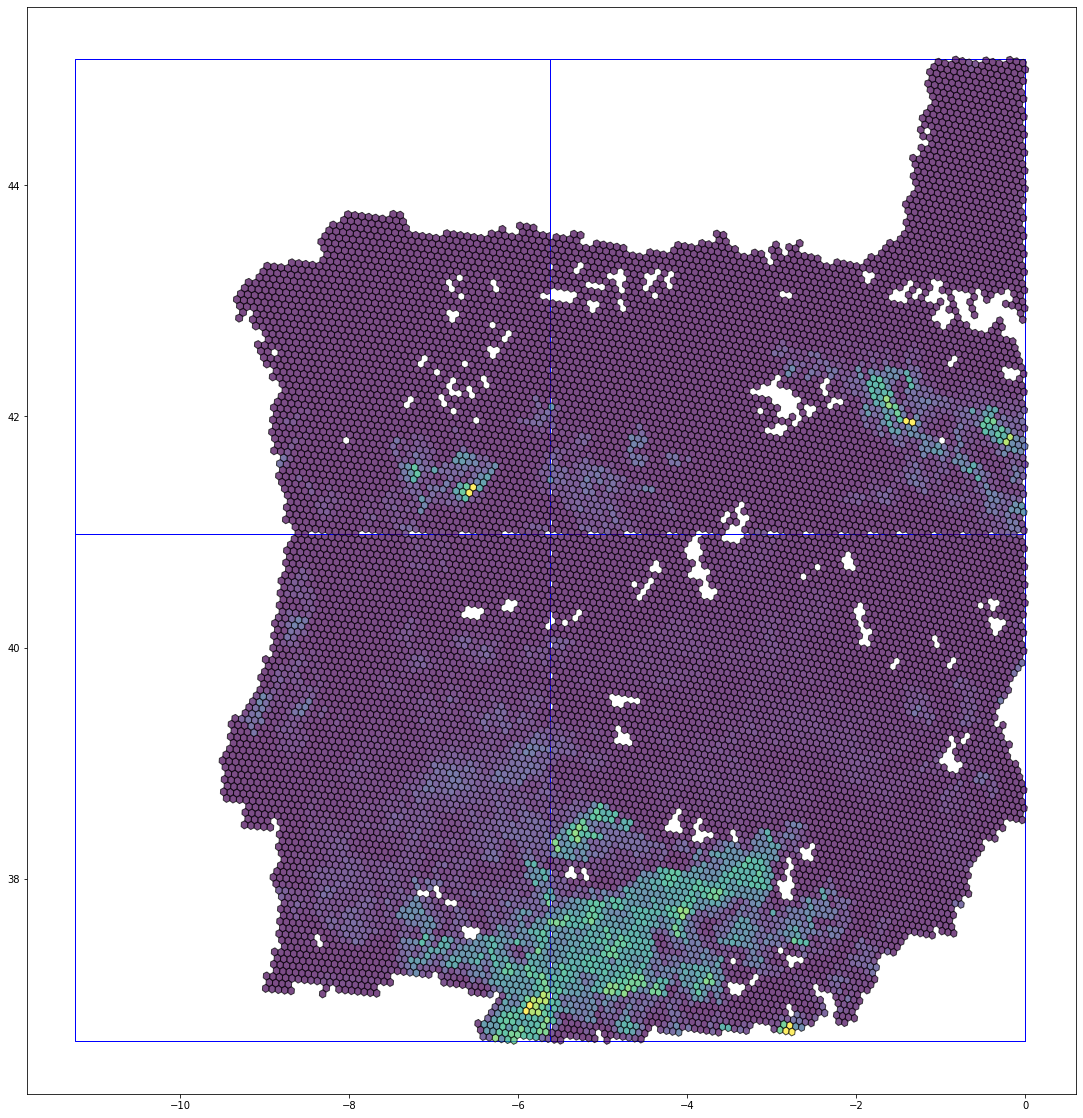

In [26]:
fig, ax = plt.subplots(figsize=(20,20))

tiles[(tiles['z'] == z) & (tiles['x'] == x) & (tiles['y'] == y)].plot(ax=ax, color='w', edgecolor='b')
gdf_zxy[(gdf_zxy['z'] == z) & (gdf_zxy['x'] == x) & (gdf_zxy['y'] == y)].plot(ax=ax, column='spam2010v2r0_global_p_ooil_a', edgecolor='k', alpha=0.7)

tiles[(tiles['z'] == z) & (tiles['x'] == x) & (tiles['y'] == y-1)].plot(ax=ax, color='w', edgecolor='b')
gdf_zxy[(gdf_zxy['z'] == z) & (gdf_zxy['x'] == x) & (gdf_zxy['y'] == y-1)].plot(ax=ax, column='spam2010v2r0_global_p_ooil_a', edgecolor='k', alpha=0.7)

tiles[(tiles['z'] == z) & (tiles['x'] == x+1) & (tiles['y'] == y)].plot(ax=ax, color='w', edgecolor='b')
gdf_zxy[(gdf_zxy['z'] == z) & (gdf_zxy['x'] == x+1) & (gdf_zxy['y'] == y)].plot(ax=ax, column='spam2010v2r0_global_p_ooil_a', edgecolor='k', alpha=0.7)

tiles[(tiles['z'] == z) & (tiles['x'] == x+1) & (tiles['y'] == y-1)].plot(ax=ax, color='w', edgecolor='b')
gdf_zxy[(gdf_zxy['z'] == z) & (gdf_zxy['x'] == x+1) & (gdf_zxy['y'] == y-1)].plot(ax=ax, column='spam2010v2r0_global_p_ooil_a', edgecolor='k', alpha=0.7)